In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import torch
import torchvision
import torchvision.transforms as tranforms



import matplotlib.pyplot as plt
#import cv2
import numpy as np

In [0]:
ROOT = '/content/drive/My Drive/Proyecto.csv/pixel/'
NOPIXEL = ROOT + 'no-pixeled/'
PIXEL= ROOT + 'pixeled/'

all_im = !ls -1 '{PIXEL}'

In [0]:
from torch.utils.data import Dataset
from PIL import Image
import random

# Define loader class
class PIX2PIXloader(Dataset):
  '''
  Loader for pix2pix applications
  '''
  def __init__(self, 
               name_list=None, 
               inp_dir=None, 
               out_dir=None, 
               dim=(286,286), 
               transform=torchvision.transforms.ToTensor()):
    
    self.transform = transform
    self.inp_name = []
    self.out_name = []
    
    for name in name_list:
      self.inp_name.append(inp_dir + name)
      self.out_name.append(out_dir + name)
    
  def __len__(self):
    return len(self.inp_name)
  
  def __getitem__(self, idx):
    inp_im = Image.open(self.inp_name[idx])
    out_im = Image.open(self.out_name[idx])
    
    seed = np.random.randint(2492759872)
      
    random.seed(seed)
    inp_im = self.transform(inp_im)
      
    random.seed(seed)
    out_im = self.transform(out_im)
    return inp_im, out_im

In [0]:
np.random.shuffle(all_im)
n = len(all_im) # Numero total de imagenes
tr_dim = round(n * 0.8) # Numero de imagenes a train
train_names = all_im[:tr_dim] # Imagenes al grupo de train
validation_names = all_im[tr_dim:] # Imagenes al grupo de validacion

transforms = torchvision.transforms.Compose([
             torchvision.transforms.Resize((300,300)),
             torchvision.transforms.RandomHorizontalFlip(),
             torchvision.transforms.RandomCrop(size=(286,286)),
             torchvision.transforms.ToTensor()
])

train_dataset = PIX2PIXloader(name_list=train_names, 
                              inp_dir=NOPIXEL,
                              out_dir=PIXEL,
                              transform=transforms)

transforms = torchvision.transforms.Compose([
             torchvision.transforms.Resize((286,286)),
             torchvision.transforms.ToTensor()
])
validation_dataset = PIX2PIXloader(name_list=validation_names, 
                                   inp_dir=NOPIXEL,
                                   out_dir=PIXEL,
                                   transform=transforms)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=1,
        num_workers=0,
        shuffle=True,
        pin_memory=True
    )

validation_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=1,
        num_workers=0,
        shuffle=True,
        pin_memory=True
    )

In [0]:
# Imprimir algunos ejemplos del grupo de entrenamiento.
for i in range(3):
  (inp, targ) = next(iter(train_loader))
  fig, ax = plt.subplots(1,2)
  ax[0].imshow(inp[0].numpy().transpose(1,2,0))
  ax[1].imshow(targ[0].numpy().transpose(1,2,0))
  plt.show()

In [0]:
# Definiciones de generador y discriminador
# Copiado de: 
#https://github.com/Eiji-Kb/simple-pix2pix-pytorch/blob/master/models.py

import torch
import torch.nn as nn
import torch.nn.functional as F


class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()

        self.c0 = nn.Conv2d(in_channels, 64, 4, stride=2, padding=1)
        self.c1 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.c2 = nn.Conv2d(128, 256, 4, stride=2, padding=1)
        self.c3 = nn.Conv2d(256, 512, 4, stride=2, padding=1)
        self.c4 = nn.Conv2d(512, 512, 4, stride=2, padding=1)
        self.c5 = nn.Conv2d(512, 512, 4, stride=2, padding=1)
        self.c6 = nn.Conv2d(512, 512, 4, stride=2, padding=1)
        self.c7 = nn.Conv2d(512, 512, 4, stride=2, padding=1)

        self.d7 = nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1)
        self.d6 = nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1)
        self.d5 = nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1)
        self.d4 = nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1,output_padding=1)
        self.d3 = nn.ConvTranspose2d(1024, 256, 4, stride=2, padding=1,output_padding=1)
        self.d2 = nn.ConvTranspose2d(512, 128, 4, stride=2, padding=1,output_padding=1)
        self.d1 = nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1, output_padding=1)
        self.d0 = nn.ConvTranspose2d(128, out_channels, 4, stride=2, padding=1)
       
        self.bnc1 = nn.BatchNorm2d(128)
        self.bnc2 = nn.BatchNorm2d(256)
        self.bnc3 = nn.BatchNorm2d(512)
        self.bnc4 = nn.BatchNorm2d(512)
        self.bnc5 = nn.BatchNorm2d(512)
        self.bnc6 = nn.BatchNorm2d(512)

        self.bnd7 = nn.BatchNorm2d(512)
        self.bnd6 = nn.BatchNorm2d(512)
        self.bnd5 = nn.BatchNorm2d(512)
        self.bnd4 = nn.BatchNorm2d(512)
        self.bnd3 = nn.BatchNorm2d(256)
        self.bnd2 = nn.BatchNorm2d(128)
        self.bnd1 = nn.BatchNorm2d(64)
        
    def forward(self, x):     
        en0 = self.c0(x)
        en1 = self.bnc1(self.c1(F.leaky_relu(en0, negative_slope=0.2)))
        en2 = self.bnc2(self.c2(F.leaky_relu(en1, negative_slope=0.2)))
        en3 = self.bnc3(self.c3(F.leaky_relu(en2, negative_slope=0.2)))
        en4 = self.bnc4(self.c4(F.leaky_relu(en3, negative_slope=0.2)))
        en5 = self.bnc5(self.c5(F.leaky_relu(en4, negative_slope=0.2)))
        en6 = self.bnc6(self.c6(F.leaky_relu(en5, negative_slope=0.2)))
        en7 = self.c7(F.leaky_relu(en6, negative_slope=0.2))

        de7 = self.bnd7(self.d7(F.relu(en7)))
        de6 = F.dropout(self.bnd6(self.d6(F.relu(torch.cat((en6, de7),1)))))
        de5 = F.dropout(self.bnd5(self.d5(F.relu(torch.cat((en5, de6),1)))))
        de4 = F.dropout(self.bnd4(self.d4(F.relu(torch.cat((en4, de5),1)))))
        de3 = self.bnd3(self.d3(F.relu(torch.cat((en3, de4),1))))
        de2 = self.bnd2(self.d2(F.relu(torch.cat((en2, de3),1))))
        de1 = self.bnd1(self.d1(F.relu(torch.cat((en1, de2),1))))

        de0 = torch.tanh(self.d0(F.relu(torch.cat((en0, de1),1))))       

        return de0


class Discriminator(nn.Module):
    def __init__(self, in_channels1, in_channels2):
        super(Discriminator, self).__init__()

        self.c0 = nn.Conv2d(in_channels1 + in_channels2, 64, 4, stride=2, padding=2)
        self.c1 = nn.Conv2d(64, 128, 4, stride=2, padding=2)
        self.c2 = nn.Conv2d(128, 256, 4, stride=2, padding=2)
        self.c3 = nn.Conv2d(256, 512, 4, stride=1, padding=2)
        self.c4 = nn.Conv2d(512, 1, 4, stride=1, padding=2)

        self.bnc1 = nn.BatchNorm2d(128)
        self.bnc2 = nn.BatchNorm2d(256)
        self.bnc3 = nn.BatchNorm2d(512)        

    def forward(self, x1, x2):
        h = self.c0(torch.cat((x1, x2),1))
        h = self.bnc1(self.c1(F.leaky_relu(h, negative_slope=0.2)))
        h = self.bnc2(self.c2(F.leaky_relu(h, negative_slope=0.2)))
        h = self.bnc3(self.c3(F.leaky_relu(h, negative_slope=0.2)))
        h = self.c4(F.leaky_relu(h, negative_slope=0.2))
        h = torch.sigmoid(h)

        return h

In [0]:
in_channels, out_channels = 3, 3
# Instanciar generador y discriminador
generator = Generator(in_channels, out_channels)
discriminator = Discriminator(in_channels, out_channels)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Device:', device)
generator.to(device)
discriminator.to(device)

In [0]:
# Definicion de funciones de error
L1 = nn.L1Loss()
loss_binaryCrossEntropy = nn.BCELoss()

# Optimizador.
gen_opt = torch.optim.Adam(generator.parameters(), lr= 0.0002, betas=(0.5, 0.999), weight_decay= 0.00001)
dis_opt = torch.optim.Adam(discriminator.parameters(), lr= 0.0002, betas=(0.5, 0.999), weight_decay= 0.00001)

In [0]:
# Definir errores en generador y discriminador
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_binaryCrossEntropy(disc_generated_output, torch.ones_like(disc_generated_output))
  
  l1_loss = L1(target, gen_output)
  
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  
  return total_gen_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_binaryCrossEntropy(disc_real_output, torch.ones_like(disc_real_output))
  
  generated_loss = loss_binaryCrossEntropy(disc_generated_output, torch.zeros_like(disc_generated_output))
  
  total_disc_loss = real_loss + generated_loss
  
  return total_disc_loss

In [0]:
# Save checkpoint
def checkpoint(PATH, generator, discriminator, epoch):
    gen_state = generator.state_dict()
    dis_state = discriminator.state_dict()
    
    ch = {
        'epoch' : epoch,
        'generator' : gen_state,
        'discriminator' : dis_state
    }
    
    filename = 'checkpoint.pth'
    
    total_path = PATH + '/' + filename
    torch.save(ch, total_path)
    print('Checkpoint saved: {}'.format(total_path))

In [0]:
from IPython.display import clear_output

def train(generator, 
          discriminator, 
          device, 
          max_epoch=1000,
          it_val=100):
  
  for epoch in range(max_epoch):
    generator.train()
    discriminator.train()
    for i, (inp, targ) in enumerate(train_loader):
      inp, targ = inp.to(device), targ.to(device)
      
      output_image = generator(inp)
      out_gen_discr = discriminator(output_image, inp)
      out_trg_discr = discriminator(targ, inp)
      
      discr_loss = discriminator_loss(out_trg_discr, out_gen_discr)
      gen_loss = generator_loss(out_gen_discr, output_image, targ)
      
      gen_opt.zero_grad()
      dis_opt.zero_grad()
      
      discr_loss.backward(retain_graph=True)
      gen_loss.backward()
      
      gen_opt.step()
      dis_opt.step()
      
    if epoch % it_val == 0:
      clear_output(wait=True)
      checkpoint('./', generator, discriminator, epoch)
      generator.eval()
      
      output_image = generator(inp)
      
      fig, ax = plt.subplots(1,3)
      ax[0].imshow(inp[0].data.cpu().numpy().transpose(1,2,0))
      ax[1].imshow(output_image[0].data.cpu().numpy().transpose(1,2,0))
      ax[2].imshow(targ[0].data.cpu().numpy().transpose(1,2,0))
      plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint saved: .//checkpoint.pth


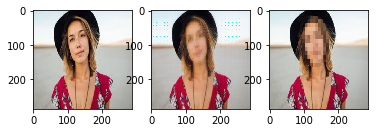

In [0]:
train(generator, discriminator,device=device, max_epoch=1000)